In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing, metrics, svm
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import norm
from xgboost import plot_importance
from pandas import DataFrame
from keras.models import Sequential  
from keras.layers import Bidirectional, LSTM, Dense  
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Input, Dropout
from tensorflow.keras.models import Model

In [2]:
# 本模块用于定义所用各种模型的类
# 定义 RNN 模型
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        out, _ = self.rnn(input)
        out = self.fc(out[:, -1, :])  # 使用最后一个时间步的输出进行预测
        return out

# 定义 GRU 模型
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        out, _ = self.gru(input)
        out = self.fc(out[:, -1, :])
        return out

# 定义 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, input):
        out, _ = self.lstm(input)
        out = self.fc(out[:, -1, :])
        return out
    
# 定义 BI_LSTM 模型
class BILSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BILSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.bilstm = nn.LSTM(input_size, hidden_size, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, input):
        out, _ = self.bilstm(input)
        out = self.fc(out[:, -1, :])  # 使用最后一个时间步的输出进行预测
        return out

 model: RNN
Epoch [20/100], Loss: 0.0405
Epoch [40/100], Loss: 0.0129
Epoch [60/100], Loss: 0.0042
Epoch [80/100], Loss: 0.0035
Epoch [100/100], Loss: 0.0033


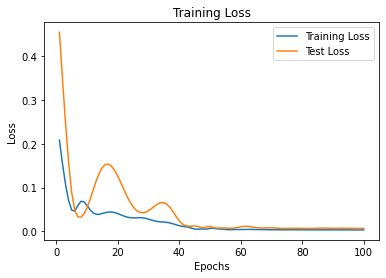

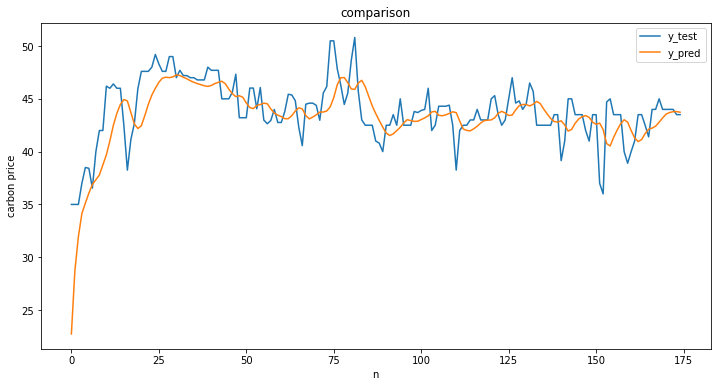

 model: GRU
Epoch [20/100], Loss: 0.0438
Epoch [40/100], Loss: 0.0312
Epoch [60/100], Loss: 0.0223
Epoch [80/100], Loss: 0.0117
Epoch [100/100], Loss: 0.0039


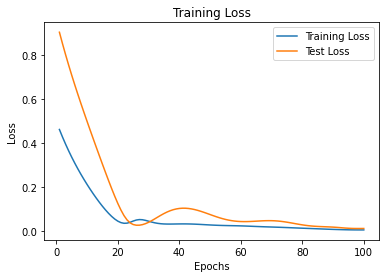

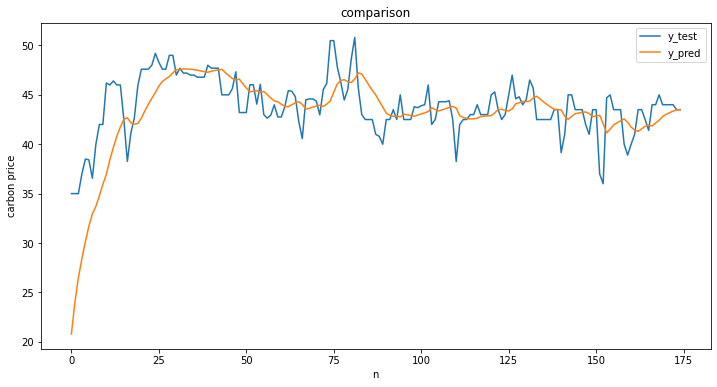

 model: LSTM
Epoch [20/100], Loss: 0.0543
Epoch [40/100], Loss: 0.0309
Epoch [60/100], Loss: 0.0186
Epoch [80/100], Loss: 0.0075
Epoch [100/100], Loss: 0.0052


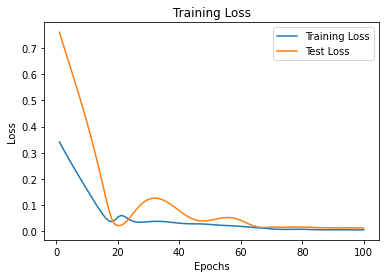

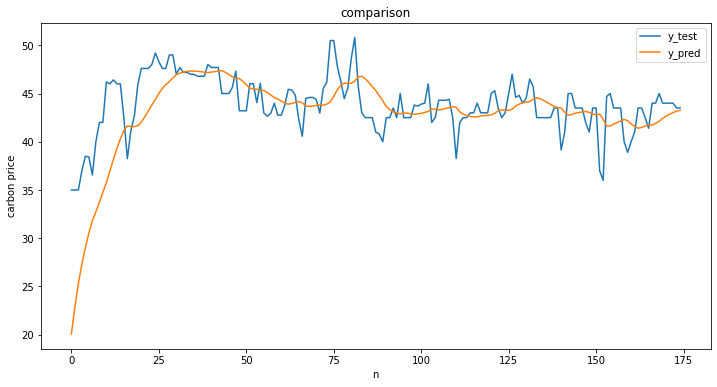

 model: BiLSTM
Epoch [20/100], Loss: 0.0407
Epoch [40/100], Loss: 0.0219
Epoch [60/100], Loss: 0.0049
Epoch [80/100], Loss: 0.0029
Epoch [100/100], Loss: 0.0022


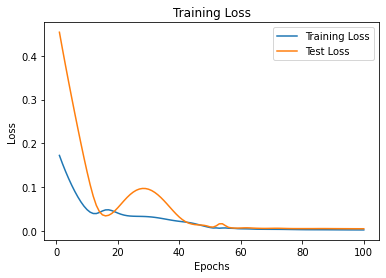

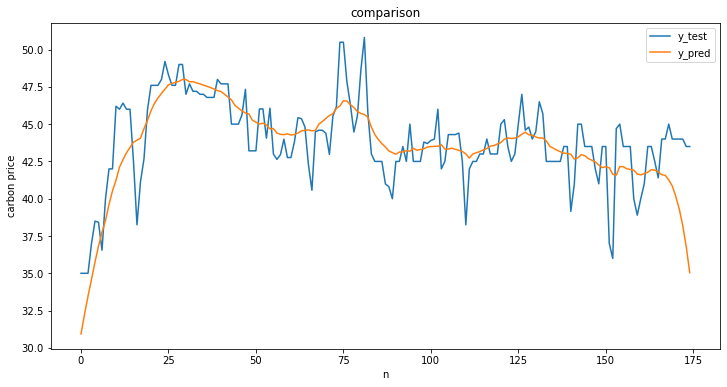

In [3]:
    # 读取数据
    data = pd.read_csv('./chq.csv')
    # 归一化数据
    labels = None
    scaler = None
    for column in data.columns:
        scaler_temp = MinMaxScaler()
        data[[column]] = scaler_temp.fit_transform(data[[column]])
        if '碳价' in column:
            scaler = scaler_temp
            labels = data[[column]]
    # 将数据转换为 PyTorch 张量
    data_tensor = torch.tensor(data.values, dtype=torch.float32)
    data_tensor_label = torch.tensor(labels.values, dtype=torch.float32)
    # 初始化模型参数
    input_size = data.shape[1]  # 输入特征维度
    hidden_size = 64  # 隐藏层维度
    output_size = 1  # 输出维度
    # 初始化模型
    models = [
        RNNModel(input_size, hidden_size, output_size),
        GRUModel(input_size, hidden_size, output_size),
        LSTMModel(input_size, hidden_size, output_size),
        BILSTMModel(input_size, hidden_size, output_size)]
    
    # 划分训练集和测试集
    train_size = int(0.8 * len(data_tensor))
    train_data = data_tensor[:train_size]
    test_data = data_tensor[train_size:]
    
    # 准备训练数据和标签
    train_input = train_data[:-1]  # 输入数据为前n-1行
    train_label = data_tensor_label[:train_size][1:].view(-1, 1)  # 标签为后n行的“碳价”列，需要进行reshape
    
    test_input = test_data[:-1]  # 增加一个维度作为批次维度
    test_label = data_tensor_label[train_size:][1:].view(-1, 1)
    test_label_ndarray = test_label.detach().numpy()
    test_label_ndarray = scaler.inverse_transform(test_label_ndarray)
    
    save_predicted_data = [test_label_ndarray.reshape(-1)]
    
    num_epochs = 100
    models_name = ['RNN', 'GRU', 'LSTM', 'BiLSTM']
    for model, model_name in zip(models, models_name):
        print(' model: {}'.format(model_name))
        
        # 定义损失函数和优化器
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # 记录每个epoch的损失和准确率
        train_losses = []
        test_losses = []

        # 开始训练模型
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            output = model(train_input.unsqueeze(1))  # LSTM 模型的输入需要增加一个维度
            loss = criterion(output, train_label)
            loss.backward()
            optimizer.step()
            
            # 计算并记录训练集上的损失
            train_loss = loss.item()
            train_losses.append(train_loss)
            
            # 计算并记录测试集的损失
            with torch.no_grad():
                test_output = model(test_input.unsqueeze(1))
                test_loss = criterion(test_output, test_label)
                test_losses.append(test_loss.item())
    
            if (epoch + 1) % 20 == 0:
                print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item()))
        
        # 绘制损失曲线
        plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
        plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()
        #plt.savefig('./data/model_{}_loss_curves.png'.format(model_name))
        plt.show()
        
        # 保存模型权重
        #torch.save(model.state_dict(), './models/{}_model.pth'.format(model_name))
        
        # # 加载模型权重
        # model.load_state_dict(torch.load('lstm_model.pth'))# 使用模型进行预测
        
        predicted_output_ndarray = model(test_input.unsqueeze(1)).detach().numpy()
        predicted_output_denormalized = scaler.inverse_transform(predicted_output_ndarray)
        
        save_predicted_data.append(predicted_output_denormalized.reshape(-1))
        
        # 可视化预测结果
        plt.figure(figsize=(12, 6))
        plt.plot(test_label_ndarray, label='y_test')
        plt.plot(predicted_output_denormalized, label='y_pred')
        plt.title('comparison')
        plt.ylabel('carbon price')
        plt.xlabel('n')
        plt.legend()
        plt.show()

In [4]:
# 时间步长
n_timestamps = 10

# 创建输入和输出数据集
def create_dataset(data, n_timestamps):
    X, y = [], []
    for i in range(len(data) - n_timestamps):
        X.append(data[i:(i + n_timestamps), :-1])  # 选择特征
        y.append(data[i + n_timestamps, -1])  # 预测目标
    return np.array(X), np.array(y)

# 使用数值数据生成特征和目标
values = data[['rf', 'gbdt','xgboost', '重庆碳价']].values
X, y = create_dataset(values, n_timestamps)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("训练集输入形状:", X_train.shape)
print("训练集输出形状:", y_train.shape)
print("测试集输入形状:", X_test.shape)
print("测试集输出形状:", y_test.shape)

训练集输入形状: (696, 10, 3)
训练集输出形状: (696,)
测试集输入形状: (174, 10, 3)
测试集输出形状: (174,)


In [8]:
# 创建 Group-CNN 模型
def create_group_cnn_model(input_shape):
    inputs = Input(shape=input_shape)

    # 第一组卷积
    x = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(inputs)
    x = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(x)

    # 第二组卷积
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x) #维度与输入个数无关！

    # 扁平化和全连接层
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)  # 输出层

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# 创建模型
model = create_group_cnn_model((X_train.shape[1], X_train.shape[2])) #维度与输入个数无关！


# 训练模型
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# 评估模型
loss = model.evaluate(X_test, y_test, verbose=0)
#print(f"测试集均方误差: {loss:.4f}")





Epoch 1/50
20/20 [==============================] - 1s 12ms/step - loss: 0.1130 - val_loss: 0.0655
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0710 - val_loss: 0.0590
Epoch 3/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0670 - val_loss: 0.0603
Epoch 4/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0663 - val_loss: 0.0639
Epoch 5/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0672 - val_loss: 0.0634
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0640 - val_loss: 0.0603
Epoch 7/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0610 - val_loss: 0.0665
Epoch 8/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0660 - val_loss: 0.0619
Epoch 9/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0620 - val_loss: 0.0588
Epoch 10/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0593 - val_loss: 0.0601
Epoch 11/50
20/20 